# Soccernet Jersey Number OCR

In [1]:
import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import cv2
import os
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import (GlobalAveragePooling2D, Conv2D, MaxPool2D, Dense,
                                     Flatten, InputLayer, BatchNormalization, Input, 
                                     Dropout,Bidirectional, LSTM ,GRU, MaxPooling2D , Reshape, RandomRotation,RandomContrast,RandomBrightness)
from tensorflow.compat.v1.keras.layers import CuDNNLSTM
from tensorflow.keras import backend as k
from tensorflow.keras.optimizers import Adam , SGD 
from tensorflow.keras.callbacks import  ReduceLROnPlateau 
from tensorflow.keras.regularizers  import L2
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Lambda
from tensorflow.keras import backend as K
from tensorflow.keras import layers
from tensorflow import keras
from tensorflow.keras.preprocessing.image import img_to_array, load_img
import mat73

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# Define paths for the SVHN (Street View House Numbers) dataset and the Soccernet dataset

# Paths for the SVHN dataset
svhn_train_mat_path = "/kaggle/input/street-view-house-numbers/train_digitStruct.mat"
svhn_test_mat_path = "/kaggle/input/street-view-house-numbers/test_digitStruct.mat"
svhn_train_img_path = "/kaggle/input/street-view-house-numbers/train/train/"
svhn_test_img_path = "/kaggle/input/street-view-house-numbers/test/test/"

# Paths for the Soccernet dataset
soccernet_train_img_path = "/kaggle/input/preprocessed-cleaned-jersey/preprocessed_jersey_extract/train/images"
soccernet_test_img_path = "/kaggle/input/preprocessed-cleaned-jersey/preprocessed_jersey_extract/test/images"


## Preprocessing the SVHN Dataset

In [4]:
svhn_train_data = mat73.loadmat(svhn_train_mat_path)
svhn_test_data = mat73.loadmat(svhn_test_mat_path)

In [6]:
def convert_to_list(value):
    if not isinstance(value, list):
        return [value]
    return value

In [7]:
char_list =['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

In [8]:
def create_svhn_dataFrame(mat_data , image_path):
    height = []
    labels = []
    left = []
    top = []
    width = []
    img_name = [image_path+name for name in mat_data["digitStruct"]["name"]]
    for item in mat_data["digitStruct"]["bbox"]:
        height.append(item['height'])
        labels.append(item['label'])
        left.append(item['left'])
        top.append(item['top'])
        width.append(item['width'])
    labels = [convert_to_list(item) for item in labels]
    max_label_len = max([len(text) for text in labels])
    height = [convert_to_list(item) for item in height]
    width = [convert_to_list(item) for item in width]
    top = [convert_to_list(item) for item in top]
    left = [convert_to_list(item) for item in left]
    labels = [[int(item)%10 for item in label] for label in labels]
    labels = [pad_sequences([label], maxlen=6, padding='post' ,value = len(char_list))[0] for label in labels]
    Dataframe = pd.DataFrame({"img_path":img_name ,'height': height, 'label': labels, 'left': left, 'top': top, 'width': width})
    
    return Dataframe

In [9]:
svhn_train_df = create_svhn_dataFrame(svhn_train_data , svhn_train_img_path)
svhn_test_df = create_svhn_dataFrame(svhn_test_data , svhn_test_img_path)

In [11]:
svhn_train_df.head()

,img_path,height,label,left,top,width
0,/kaggle/input/street-view-house-numbers/train/...,"[219.0, 219.0]","[1, 9, 10, 10, 10, 10]","[246.0, 323.0]","[77.0, 81.0]","[81.0, 96.0]"
1,/kaggle/input/street-view-house-numbers/train/...,"[32.0, 32.0]","[2, 3, 10, 10, 10, 10]","[77.0, 98.0]","[29.0, 25.0]","[23.0, 26.0]"
2,/kaggle/input/street-view-house-numbers/train/...,"[15.0, 15.0]","[2, 5, 10, 10, 10, 10]","[17.0, 25.0]","[5.0, 5.0]","[8.0, 9.0]"
3,/kaggle/input/street-view-house-numbers/train/...,"[34.0, 34.0]","[9, 3, 10, 10, 10, 10]","[57.0, 72.0]","[13.0, 13.0]","[15.0, 13.0]"
4,/kaggle/input/street-view-house-numbers/train/...,"[46.0, 46.0]","[3, 1, 10, 10, 10, 10]","[52.0, 74.0]","[7.0, 10.0]","[21.0, 15.0]"


In [12]:
svhn_test_df.head()

,img_path,height,label,left,top,width
0,/kaggle/input/street-view-house-numbers/test/t...,[30.0],"[5, 10, 10, 10, 10, 10]",[43.0],[7.0],[19.0]
1,/kaggle/input/street-view-house-numbers/test/t...,"[23.0, 23.0, 23.0]","[2, 1, 0, 10, 10, 10]","[99.0, 114.0, 121.0]","[5.0, 8.0, 6.0]","[14.0, 8.0, 12.0]"
2,/kaggle/input/street-view-house-numbers/test/t...,[16.0],"[6, 10, 10, 10, 10, 10]",[61.0],[6.0],[11.0]
3,/kaggle/input/street-view-house-numbers/test/t...,[17.0],"[1, 10, 10, 10, 10, 10]",[32.0],[6.0],[14.0]
4,/kaggle/input/street-view-house-numbers/test/t...,[28.0],"[9, 10, 10, 10, 10, 10]",[97.0],[28.0],[19.0]


[array([ 3,  8,  8, 10, 10, 10], dtype=int32)]


(-0.5, 46.5, 20.5, -0.5)

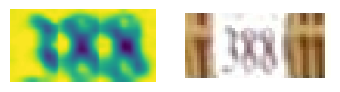

In [13]:
import math
row = svhn_train_df.iloc[4574]
img  = cv2.imread(row["img_path"])
top_list = row['top']
left_list = row['left']
height_list = row['height']
width_list = row['width']
label_list = row['label']

concatenated_roi = None
labels = []
preprocessed_images = []

common_height = 32  # Set a common height for all ROIs

for i in range(len(top_list)):
    top = abs(top_list[i])
    left = abs(left_list[i])
    height = abs(height_list[i])
    width = abs(width_list[i])

    object_roi = img[int(top):int(top + height), int(left):int(left + width)]

    # Resize each ROI to the common height
    resized_object_roi = cv2.resize(object_roi, (int(width / height * common_height), common_height))

    if concatenated_roi is None:
        concatenated_roi = resized_object_roi
    else:
        concatenated_roi = np.concatenate((concatenated_roi, resized_object_roi), axis=1)

labels.append(label_list)

resized_concatenated_roi = cv2.resize(concatenated_roi, (64, 32))
grayscale_concatenated_roi = cv2.cvtColor(resized_concatenated_roi, cv2.COLOR_BGR2GRAY)

preprocessed_images.append(grayscale_concatenated_roi)


print(labels)
plt.subplot(1 , 3,1)
plt.imshow(preprocessed_images[0])
plt.axis("off")
plt.subplot(1 , 3,2)
plt.imshow(img)
plt.axis("off")
plt.axis("off")


In [14]:
def preprocess_and_extract_roi(row):
    img = cv2.imread(row['img_path'])
    if img is None:
        return None, None

    top_list = row['top']
    left_list = row['left']
    height_list = row['height']
    width_list = row['width']
    label_list = row['label']

    concatenated_roi = None
    labels = []
    preprocessed_images = []

    common_height = 32  # Set a common height for all ROIs

    for i in range(len(top_list)):
        top = abs(top_list[i])
        left = abs(left_list[i])
        height = abs(height_list[i])
        width = abs(width_list[i])

        object_roi = img[int(top):int(top + height), int(left):int(left + width)]

        # Resize each ROI to the common height
        resized_object_roi = cv2.resize(object_roi, (int(width / height * common_height), common_height))

        if concatenated_roi is None:
            concatenated_roi = resized_object_roi
        else:
            concatenated_roi = np.concatenate((concatenated_roi, resized_object_roi), axis=1)

    labels.append(label_list)

    resized_concatenated_roi = cv2.resize(concatenated_roi, (64, 32))
    grayscale_concatenated_roi = cv2.cvtColor(resized_concatenated_roi, cv2.COLOR_BGR2GRAY)

    preprocessed_images.append(grayscale_concatenated_roi)

    return preprocessed_images, labels


In [15]:
def preprocess_and_extract_roi_batch(dataframe):
    preprocessed_images = []
    labels = []

    for index, row in dataframe.iterrows():
        images, lbls = preprocess_and_extract_roi(row)
        if images is not None and lbls is not None:
            preprocessed_images.extend(images)
            labels.extend(lbls)

    return preprocessed_images, labels

In [16]:
svhn_train_preprocessed_images, svhn_train_labels = preprocess_and_extract_roi_batch(svhn_train_df)
svhn_train_preprocessed_images = np.array(svhn_train_preprocessed_images)
svhn_train_labels = np.array(svhn_train_labels)

In [17]:
svhn_test_preprocessed_images, svhn_test_labels = preprocess_and_extract_roi_batch(svhn_test_df)
svhn_test_preprocessed_images = np.array(svhn_test_preprocessed_images)
svhn_test_labels = np.array(svhn_test_labels)

/opt/conda/lib/python3.10/site-packages/matplotlib/text.py:1279: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


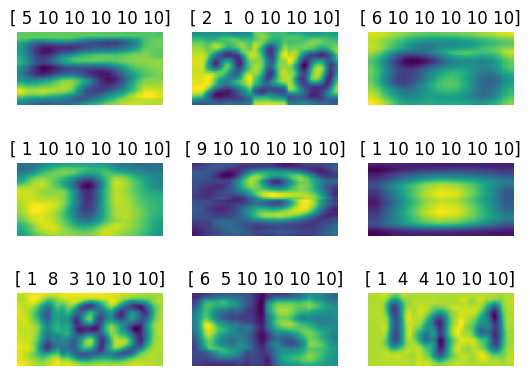

In [18]:
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(svhn_test_preprocessed_images[i])
    plt.axis("off")
    plt.title(svhn_test_labels[i])

In [19]:
svhn_train_dataset = tf.data.Dataset.from_tensor_slices((svhn_train_preprocessed_images, svhn_train_labels))
svhn_test_dataset = tf.data.Dataset.from_tensor_slices((svhn_test_preprocessed_images, svhn_test_labels))

## Preprocessing the SoccerNet Dataset

In [20]:
def create_soccernet_dataframe(path):
    labels = []
    paths = []
    for directory_name in os.listdir(path):

        directory_path = os.path.join(path, directory_name)
        if os.path.isdir(directory_path):
                for filename in os.listdir(directory_path):
                    file_path = os.path.join(directory_path, filename)
                    if str(directory_name) == "-1":
                        labels.append([10])
                    else:
                        labels.append([int(digit) for digit in str(directory_name)])
                    paths.append(file_path)
        else:
            print("Not a directory:", directory_path)


    labels = [pad_sequences([label], maxlen=6, padding='post' ,value =10)[0] for label in labels]
    return pd.DataFrame({"Image_Path": paths, "Labels": labels})



soccernet_train_df = create_soccernet_dataframe(soccernet_train_img_path)
soccernet_test_df = create_soccernet_dataframe(soccernet_test_img_path)

def preprocess_images_labels(row):
    img = cv2.imread(row['Image_Path'])
    if img is None:
        return None, None


    label_list = row['Labels']

    labels = []
    preprocessed_images = []

    labels.append(label_list)

    resized_img = cv2.resize(img, (64, 32))
    grayscale_img = cv2.cvtColor(resized_img, cv2.COLOR_BGR2GRAY)

    preprocessed_images.append(grayscale_img)

    return preprocessed_images, labels
def extract_roi_batch_from_dataframe(dataframe):
    preprocessed_images = []
    labels = []

    for index, row in dataframe.iterrows():
        images, lbls = preprocess_images_labels(row)
        if images is not None and lbls is not None:
            preprocessed_images.extend(images)
            labels.extend(lbls)

    return preprocessed_images, labels

In [ ]:
soccernet_train_preprocessed_images, soccernet_train_labels = extract_roi_batch_from_dataframe(soccernet_train_df)
soccernet_train_preprocessed_images = np.array(soccernet_train_preprocessed_images)
soccernet_train_labels = np.array(soccernet_train_labels)

soccernet_test_preprocessed_images, soccernet_test_labels = extract_roi_batch_from_dataframe(soccernet_test_df)
soccernet_test_preprocessed_images = np.array(soccernet_test_preprocessed_images)
soccernet_test_labels = np.array(soccernet_test_labels)

In [ ]:
soccernet_train_dataset = tf.data.Dataset.from_tensor_slices((soccernet_train_preprocessed_images, soccernet_train_labels))
soccernet_test_dataset = tf.data.Dataset.from_tensor_slices((soccernet_test_preprocessed_images, soccernet_test_labels))

In [ ]:
def process_single_sample(img, label):
    return {"image": img, "label": label}

In [ ]:
batch_size = 128
soccernet_train_dataset = (soccernet_train_dataset
                           .map(process_single_sample)
                           .batch(batch_size)
                           .prefetch(tf.data.AUTOTUNE))
soccernet_test_dataset = (soccernet_test_dataset
                          .map(process_single_sample)
                          .batch(batch_size)
                          .prefetch(tf.data.AUTOTUNE))

## Merging SVHN and SoccerNet Datasets

In [22]:
def merge_datasets(train_dataset, test_dataset):
    """Merges two TensorFlow datasets while preserving label information.

    Args:
        train_dataset: A TensorFlow dataset representing the training data.
        test_dataset: A TensorFlow dataset representing the testing data.

    Returns:
        A merged TensorFlow dataset containing both training and testing data.
    """

    # Ensure both datasets have the same structure (images, labels)
    train_element = next(iter(train_dataset))
    test_element = next(iter(test_dataset))

    if len(train_element) != len(test_element):
        raise ValueError("Datasets must have the same structure (image, label)")

    # Create a new dataset from the concatenation of train and test datasets
    merged_dataset = train_dataset.concatenate(test_dataset)

    return merged_dataset

# Assuming you have already created train1_dataset_1 and test1_dataset_1
train_merged_dataset = merge_datasets(svhn_train_dataset, soccernet_train_dataset)
test_merged_dataset = merge_datasets(svhn_test_dataset, soccernet_test_dataset)

# Further processing (optional)



In [23]:
batch_size = 128
train_merged_dataset = (train_merged_dataset
                        .map(process_single_sample)
                        .shuffle(buffer_size=10000)
                        .batch(batch_size)
                        .prefetch(tf.data.AUTOTUNE))
test_merged_dataset =(test_merged_dataset
                      .map(process_single_sample)
                      .shuffle(buffer_size=10000)
                      .batch(batch_size)
                      .prefetch(tf.data.AUTOTUNE))

In [24]:
train_merged_dataset

<_PrefetchDataset element_spec={'image': TensorSpec(shape=(None, 32, 64), dtype=tf.uint8, name=None), 'label': TensorSpec(shape=(None, 6), dtype=tf.int32, name=None)}>

In [26]:
soccernet_test_dataset

<_PrefetchDataset element_spec={'image': TensorSpec(shape=(None, 32, 64), dtype=tf.uint8, name=None), 'label': TensorSpec(shape=(None, 6), dtype=tf.int32, name=None)}>

## Model Creation

In [27]:
from itertools import groupby
char_list =['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
def ctc_decoder(predictions):
    '''
    input: given batch of predictions from text rec model
    output: return lists of raw extracted text

    '''
    text_list = []
    
    pred_indcies = np.argmax(predictions, axis=-1)
    
    for i in range(pred_indcies.shape[0]):
        ans = ""
        
        ## merge repeats
        merged_list = [k for k,_ in groupby(pred_indcies[i])]
        
        ## remove blanks
        for p in merged_list:
            if p != len(char_list):
                ans += char_list[int(p)]
        
        text_list.append(ans)
        
    return text_list

In [28]:
def ctc_accuracy(y_pred , y_true):
    pred_text = ctc_decoder(y_pred)
    org_text = []
    for i in range(len(y_true)):
        ans=""
        for p in y_true[i]:
            if p != 10:
                ans += str(p)
        org_text.append(ans)
    correct_predictions = sum([1 for pred, true in zip(pred_text, org_text) if pred == true])
    total_samples = len(y_pred)
    accuracy = correct_predictions / total_samples if total_samples > 0 else 0.0

    tf.print("CTC Accuracy:", accuracy)

In [29]:
figures_list = []

class PlotPredictions(tf.keras.callbacks.Callback):

    def __init__(self, frequency=1):
        self.frequency = frequency
        super(PlotPredictions, self).__init__()

        batch = test_merged_dataset.take(7)
        self.batch_images = list(batch.as_numpy_iterator())[0]["image"]
        self.batch_labels = list(batch.as_numpy_iterator())[0]["label"]

    def plot_predictions(self, epoch):

        prediction_model = keras.models.Model(
            self.model.get_layer(name="image").input, 
            self.model.get_layer(name="dense").output
        )
        
        preds = prediction_model.predict(self.batch_images)
        pred_texts = ctc_decoder(preds)
        

        orig_texts = []

        for label in self.batch_labels:
            orig_texts.append("".join([char_list[int(char_ind)] for char_ind in label if not(char_ind == len(char_list))]))

        fig , ax = plt.subplots(4, 4, figsize=(15, 5))
        fig.suptitle('Epoch: '+str(epoch), weight='bold', size=14)

        for i in range(16):

            img = (self.batch_images[i, :, :] * 255).astype(np.uint8)
            title = f"Prediction: {pred_texts[i]}"
            ax[i // 4, i % 4].imshow(img, cmap="gray")
            ax[i // 4, i % 4].set_title(title)
            ax[i // 4, i % 4].axis("off")
        
        plt.show()

        figures_list.append(fig)

    def on_epoch_end(self, epoch, logs=None):
        if epoch % self.frequency == 0:
            self.plot_predictions(epoch)

In [31]:
class CTCLayer(layers.Layer):

    def __init__(self, name=None):

        super().__init__(name=name)
        self.loss_fn = K.ctc_batch_cost

    def call(self, y_true, y_pred):
        # Compute the training-time loss value and add it
        # to the layer using `self.add_loss()`.

        batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
        input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
        label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

        input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)

        # At test time, just return the computed predictions
        return y_pred

In [44]:
inputs = Input(shape=(32, 64, 1), name="image")


labels = layers.Input(name="label", shape=(None,), dtype="float32")


conv_1 = Conv2D(32, (3,3), kernel_initializer="he_uniform" ,activation = "selu", padding='same')(inputs)
pool_1 = MaxPool2D(pool_size=(2, 2))(conv_1)

conv_2 = Conv2D(64, (3,3), activation = "selu", padding='same')(pool_1)
pool_2 = MaxPool2D(pool_size=(2, 2))(conv_2)


conv_3 = Conv2D(128, (3,3), activation = "selu", padding='same')(pool_2)
conv_4 = Conv2D(128, (3,3), activation = "selu", padding='same')(conv_3)

drop_4  = Dropout(0.3)(conv_4)
pool_4 = MaxPool2D(pool_size=(2, 1))(drop_4)

conv_5 = Conv2D(256, (3,3), activation = "selu", padding='same')(pool_4)

# Batch normalization layer
batch_norm_5 = BatchNormalization()(conv_5)

conv_6 = Conv2D(256, (3,3), activation = "selu", padding='same')(batch_norm_5)
batch_norm_6 = BatchNormalization()(conv_6)
pool_6 = MaxPool2D(pool_size=(2, 1))(batch_norm_6)

conv_7 = Conv2D(64, (2,2), activation = "selu")(pool_6)
drop_7  = Dropout(0.3)(conv_7)
squeezed = Lambda(lambda x: K.squeeze(x, 1))(drop_7)

# bidirectional LSTM layers with units=128
blstm_1 = Bidirectional(GRU(128, return_sequences=True , dropout=0.3))(squeezed)
blstm_2 = Bidirectional(GRU(128, return_sequences=True , dropout=0.2))(blstm_1)


softmax_output = Dense(len(char_list) + 1, activation = 'softmax', name="dense")(blstm_2)


output = CTCLayer(name="ctc_loss")(labels, softmax_output)

optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, clipnorm=1.0)


#model to be used at training time
model = Model(inputs=[inputs, labels], outputs=output)
model.compile(optimizer = optimizer)


print(model.summary())


Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 image (InputLayer)          [(None, 32, 64, 1)]          0         []                            
                                                                                                  
 conv2d_7 (Conv2D)           (None, 32, 64, 32)           320       ['image[0][0]']               
                                                                                                  
 max_pooling2d_4 (MaxPoolin  (None, 16, 32, 32)           0         ['conv2d_7[0][0]']            
 g2D)                                                                                             
                                                                                                  
 conv2d_8 (Conv2D)           (None, 16, 32, 64)           18496     ['max_pooling2d_4[0][0]'

In [45]:
len(test_merged_dataset)

495

### Callbacks

In [46]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.75, patience=3, min_delta=0.001, cooldown=2, verbose=1)
callbacks_list = [
   # PlotPredictions(frequency=1),
    reduce_lr,
                 ]
                 

## Model Training

In [47]:
history = model.fit(train_merged_dataset, 
                        epochs = 35,
                        validation_data=test_merged_dataset,
                        callbacks = callbacks_list,
                        verbose = 1,
                        shuffle=True)

Epoch 1/35


2024-05-06 08:52:58.864875: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_2/dropout_3/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


730/730 [==============================] - 91s 112ms/step - loss: 1.8719 - val_loss: 2.4661 - lr: 0.0010
Epoch 2/35
730/730 [==============================] - 79s 108ms/step - loss: 0.6644 - val_loss: 1.7246 - lr: 0.0010
Epoch 3/35
730/730 [==============================] - 79s 109ms/step - loss: 0.4309 - val_loss: 1.0093 - lr: 0.0010
Epoch 4/35
730/730 [==============================] - 79s 108ms/step - loss: 0.3340 - val_loss: 0.8227 - lr: 0.0010
Epoch 5/35
730/730 [==============================] - 79s 109ms/step - loss: 0.2809 - val_loss: 0.8619 - lr: 0.0010
Epoch 6/35
730/730 [==============================] - 79s 108ms/step - loss: 0.2477 - val_loss: 1.3195 - lr: 0.0010
Epoch 7/35
729/730 [============================>.] - ETA: 0s - loss: 0.2321
Epoch 7: ReduceLROnPlateau reducing learning rate to 0.0007500000356230885.
730/730 [==============================] - 79s 109ms/step - loss: 0.2319 - val_loss: 0.9570 - lr: 0.0010
Epoch 8/35
730/730 [==============================] - 79s

In [48]:
model.evaluate(soccernet_test_dataset)

393/393 [==============================] - 22s 56ms/step - loss: 0.4227


0.4226774275302887

In [49]:
prediction_model = keras.models.Model(
    model.get_layer(name="image").input, 
    model.get_layer(name="dense").output 
)

In [38]:
# Initialize empty lists to store the images and labels
all_images = []
all_labels = []

# Iterate through the entire val_dataset to accumulate the images and labels
for batch in soccernet_test_dataset:
    images = batch["image"]  # Access the image tensor for the current batch
    labels = batch["label"]  # Access the label tensor for the current batch

    all_images.append(images)  # Append the images to the list
    all_labels.append(labels)  # Append the labels to the list

# Convert the lists to NumPy arrays if needed
all_images = np.concatenate(all_images, axis=0)  # Concatenate the list of images into a single array
all_labels = np.concatenate(all_labels, axis=0)  # Concatenate the list of labels into a single array


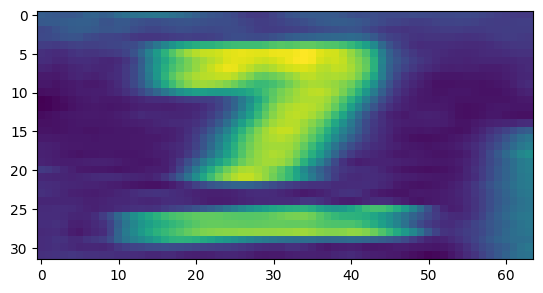

In [39]:
plt.imshow(all_images[1000])

In [40]:
all_labels[1000]

array([ 7, 10, 10, 10, 10, 10], dtype=int32)

In [41]:
import random

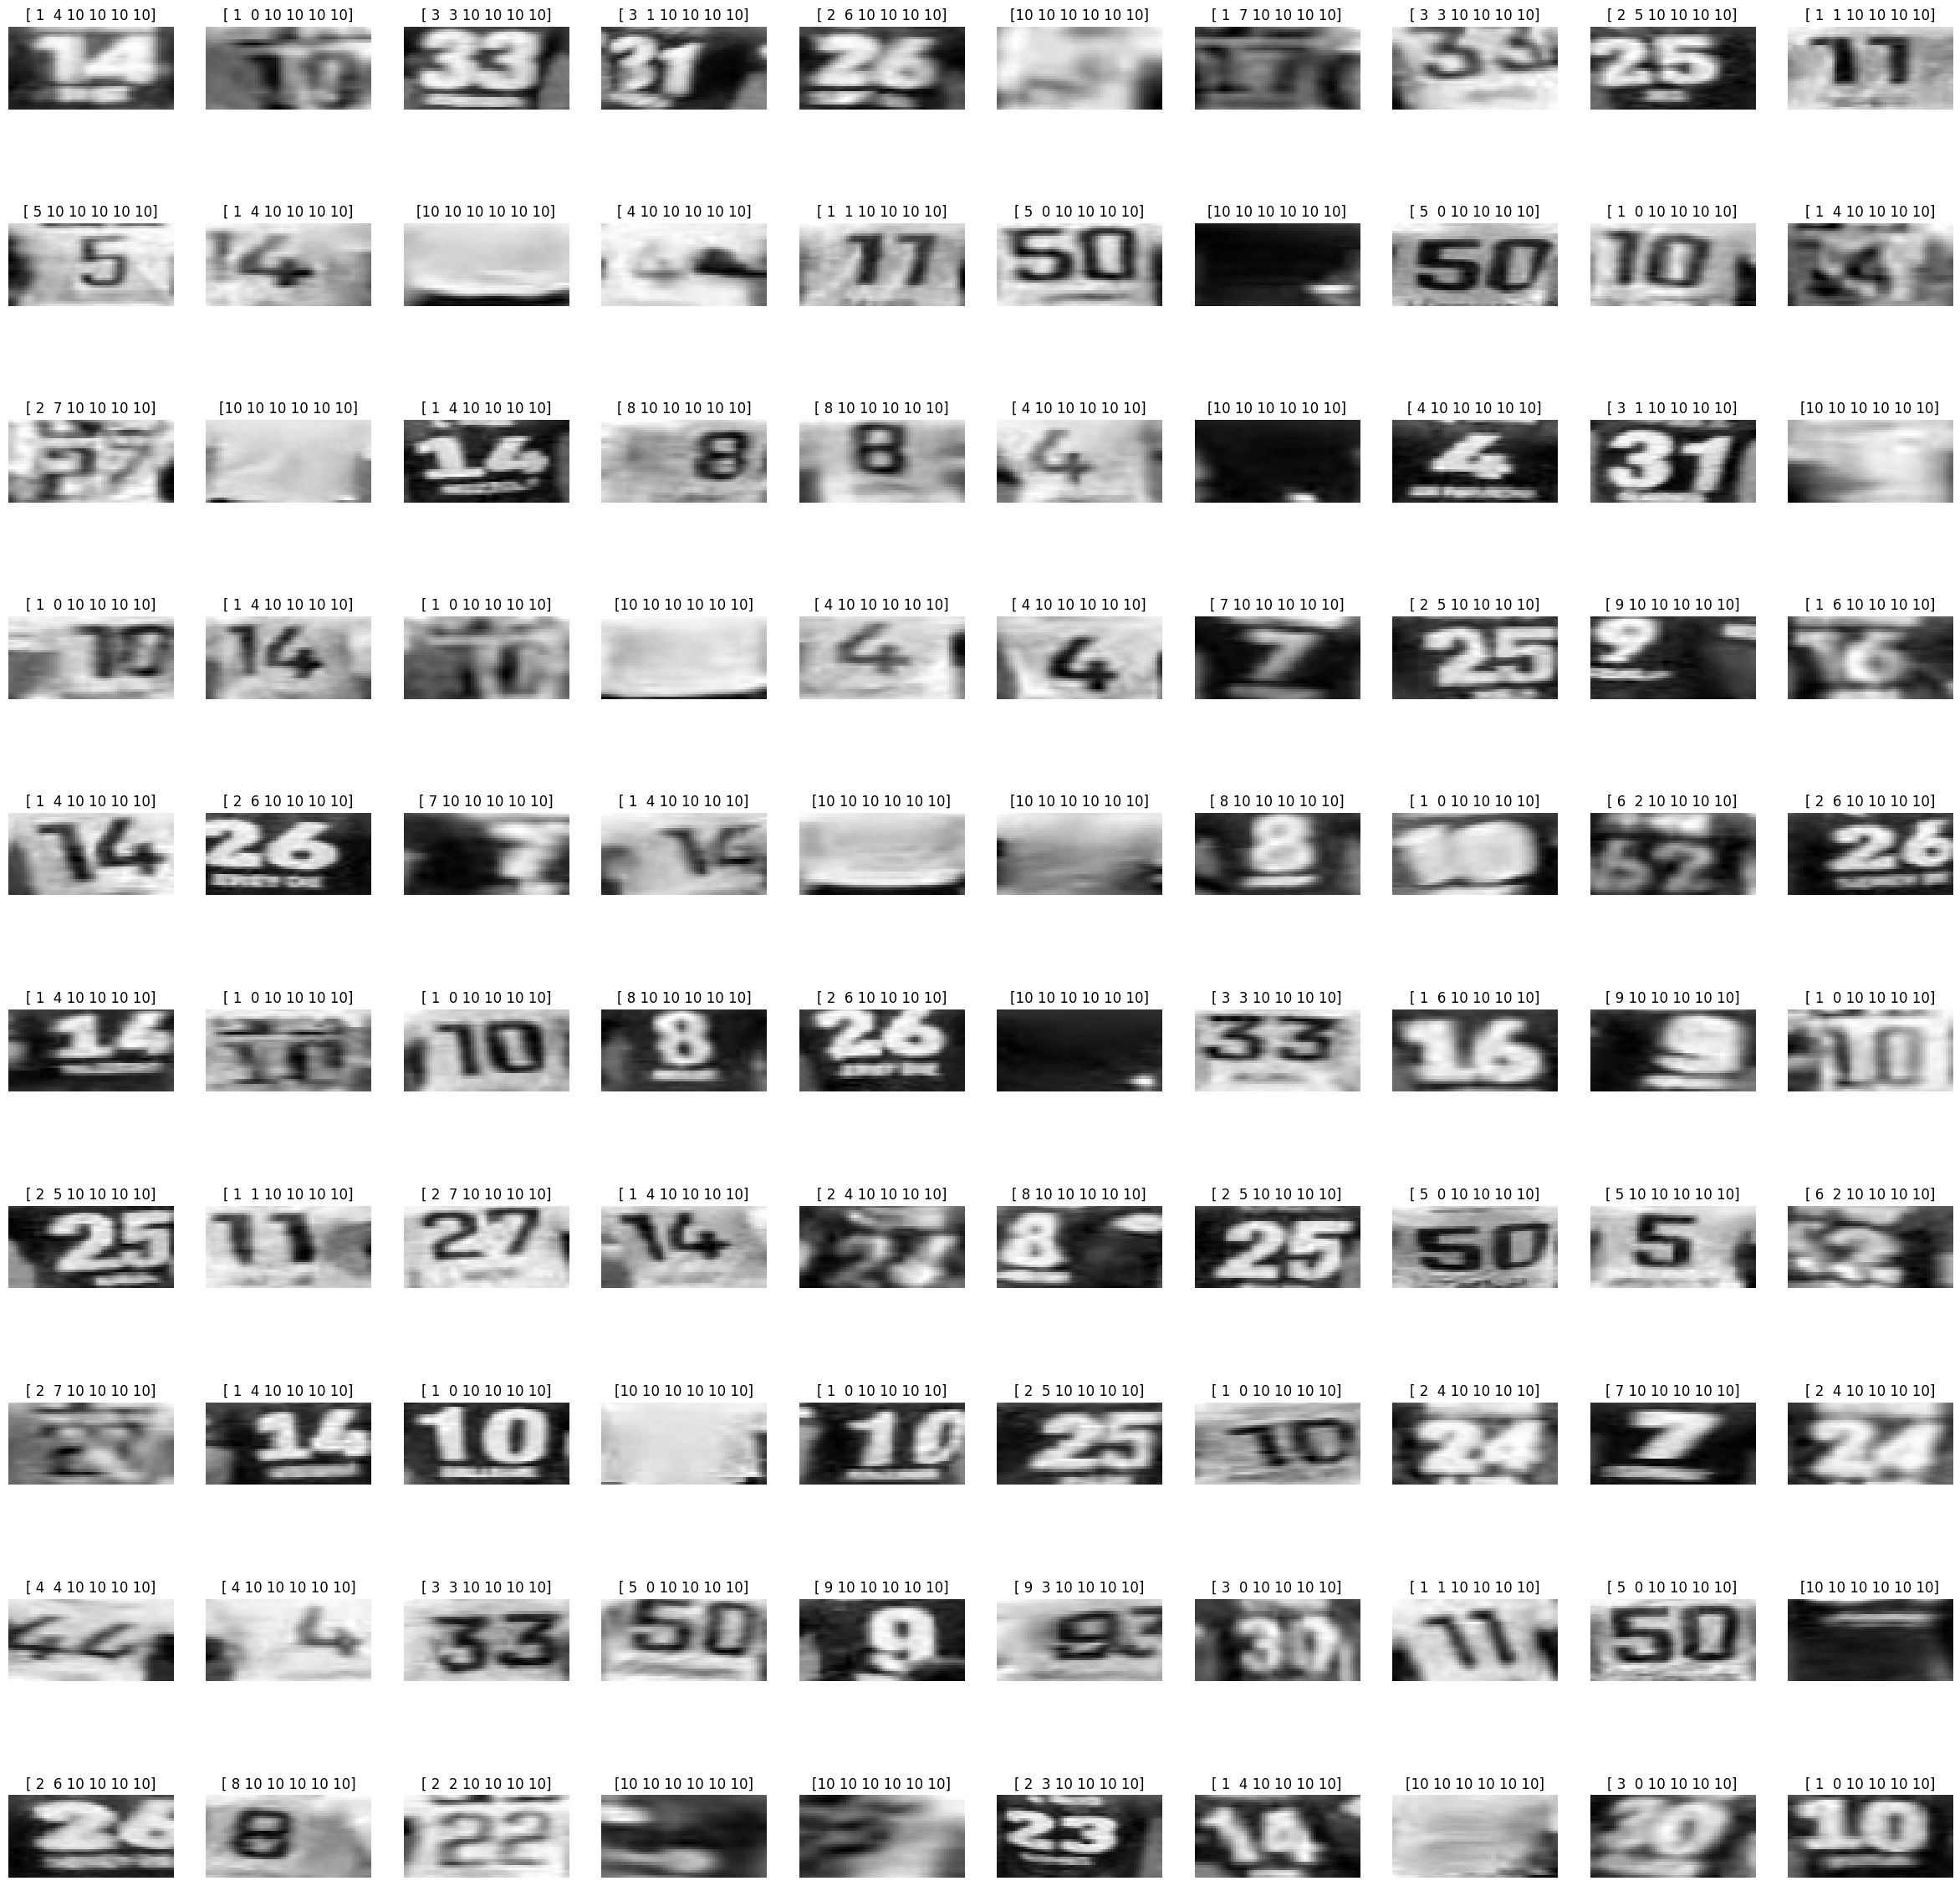

In [42]:
plt.figure(figsize=(30,30))
for i in range(100):
    ran =random.randint(0,len(all_images))
    plt.subplot(10,10,i+1)
    plt.imshow(all_images[ran] ,cmap="gray")
    plt.axis("off")
    plt.title(all_labels[ran])

In [50]:
# Define your ctc_accuracy function
def ctc_accuracy(prediction_model, all_images, all_labels, batch_size=1000):
    total_correct = 0
    total_samples = 0

    # Iterate over batches
    for i in range(0, len(all_images), batch_size):
        batch_images = all_images[i:i+batch_size]
        batch_labels = all_labels[i:i+batch_size]

        # Perform prediction on the batch
        y_pred = prediction_model(batch_images)

        # Decode predictions
        pred_text = ctc_decoder(y_pred)

        # Convert labels to strings
        org_text = []
        for labels in batch_labels:
            ans = ''.join([str(label) for label in labels if label != 10])
            org_text.append(ans)

        # Compute accuracy for the batch
        correct_predictions = sum([1 for pred, true in zip(pred_text, org_text) if pred == true])
        total_correct += correct_predictions
        total_samples += len(batch_images)

    # Compute overall accuracy
    overall_accuracy = total_correct / total_samples if total_samples > 0 else 0.0

    return overall_accuracy

# Call your ctc_accuracy function
overall_accuracy = ctc_accuracy(prediction_model, all_images, all_labels)
print("Overall CTC Accuracy:", overall_accuracy)

Overall CTC Accuracy: 0.927744630071599


In [51]:
prediction_model.save("model93.hdf5")

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [152]:
loaded_model = tf.keras.models.load_model("/kaggle/input/gru-model/GRUmodel.hdf5")

In [177]:
new_image_path = "/kaggle/input/number-for-testing/4.jpg"
new_image = cv2.imread(new_image_path)
new_image = cv2.resize(new_image, (64, 32))  
new_image = cv2.cvtColor(new_image ,  cv2.COLOR_BGR2GRAY)
new_image = np.expand_dims(new_image, axis=0)  

In [178]:
preds = prediction_model.predict(new_image)
pred_texts = ctc_decoder(preds)
print(pred_texts)

1/1 [==============================] - 0s 26ms/step
['4']
